# Importing all the libraries

In [1]:
import tweepy
import json
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
import numpy as np
from IPython.display import display
import seaborn as sns  

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from textblob import TextBlob


import nltk 
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import TweetTokenizer
from nltk.probability import FreqDist
from nltk import WordPunctTokenizer


from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score





# Use keys given by twitter to access API

In [3]:
consumer_key="XXXXXX"

In [4]:
consumer_key_secret = "XXXXXX"

In [5]:
access_token="XXXXXX"

In [6]:
access_token_secret="XXXXX"

In [7]:
auth = tweepy.OAuthHandler(consumer_key,consumer_key_secret)

In [8]:
auth.set_access_token(access_token,access_token_secret)

In [9]:
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)


# Preprocesing, definig colors for graphs and creating a DataFrame

In [10]:
import re
import string
def preprocess_one(text):
    #removing punctuation
    clean=[char for char in text if char not in string.punctuation]
    #join chars after removing punc
    clean=''.join(clean)
    #convert to lowercase
    clean=clean.lower()
    #remove URLs
    clean=re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', clean)
    clean=re.sub(r'http\S+','',clean)
    #remove usernames
    clean=re.sub(r'@[^\s]+', '', clean)
    #removing # 
    clean=re.sub(r'#([^\s]+)',r'\1',clean)
    #removing RT
    clean=re.sub(r'rt','',clean)
    #remove repeated chars
    clean=word_tokenize(clean)
    #remove stop words
    return[word for word in clean if word not in stopwords.words('english')]

def preprocess_two(x):
    x = x.lower()
    x = re.sub(r'@[A-Za-z0-9]+','',x)#remove usernames
    x = re.sub(r'^rt[\s]+', '', x)
    x = re.sub('https?://[A-Za-z0-9./]+','',x) # remove url
    x = re.sub(r'#([^\s]+)', r'\1', x)# remove hastags
    x = re.sub('[^a-zA-Z]', ' ', x)
    #x= re.sub(r':','',x)
    tok = WordPunctTokenizer()
    words = tok.tokenize(x)
    x = (' '.join(words)).strip()
    #return [word for word in x if word not in stopwords.words('english')]
    return x

# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
 
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])
 
# all emoticons (happy + sad)
emoticons = emoticons_happy.union(emoticons_sad)
 


redshadeone=[0.803, 0.380, 0.333]
redshadetwo=[0.925, 0.439, 0.388]
burbleone=[0.686, 0.478, 0.772]
burbletwo=[0.647, 0.411, 0.741]
blueone=[0.647, 0.411, 0.741]
bluetwo=[0.364, 0.678, 0.886]
cyanone=[0.282, 0.788, 0.690]
cyantwo=[0.270, 0.701, 0.615]
greenone=[0.321, 0.745, 0.501]
greentwo=[0.270, 0.701, 0.615]
anothergreenone=[0.321, 0.745, 0.501]
anothergreentwo=[0.345, 0.839, 0.552]
yellowone=[0.956, 0.815, 0.247]
yellowtwo=[0.960, 0.690, 0.254]
orangeone=[0.921, 0.596, 0.305]
orangetwo=[0.862, 0.462, 0.2]

epic_colors=[redshadeone,redshadetwo,burbleone,burbletwo,blueone,bluetwo,cyanone,cyantwo,
            greenone,greentwo,anothergreenone,anothergreentwo,yellowone,yellowtwo,
            orangeone,orangetwo]
epic_colors_senti_bar=[cyantwo,redshadetwo,yellowone]
colors=[greentwo,blueone,redshadetwo]


#user searching for tweets
search=input("Enter what you want to search: ")
print()

#creating the df

data={'Tweets':[],'Tags':[],'Cleaned Tweets':[],'Sentiment':[],'Polarity':[],
      'Vader Pos':[],'Vader Neg':[],'Vader Neu':[],'Vader Compound':[],'Subjectivity':[],'Subject':[]}

data_nltk={'Tweets':[],'Cleaned Tweets':[],'Tokenized':[]}




#tweet tokenizer to split the tweets into words
tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True)


positive=0
negative=0
neutral=0

positive_vader=0
negative_vader=0
neutral_vader=0


Enter what you want to search: Black Lives Matter



# Accessing tweets and calculating sentiment scores; flooding the DF with our data


In [11]:
def sentiment_scores(sentence): 
  
    # Create a SentimentIntensityAnalyzer object. 
    sid_obj = SentimentIntensityAnalyzer() 
  
    # polarity_scores method of SentimentIntensityAnalyzer 
    # oject gives a sentiment dictionary. 
    # which contains pos, neg, neu, and compound scores. 
    sentiment_dict = sid_obj.polarity_scores(sentence) 
      
    #print("Overall sentiment dictionary is : ", sentiment_dict) 
    #print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative") 
    
    data['Vader Neg'].append(sentiment_dict['neg'])
    
    #print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral") 
    
    data['Vader Neu'].append(sentiment_dict['neu'])
    
    #print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive") 
    
    data['Vader Pos'].append(sentiment_dict['pos'])
  
    #print("Sentence Overall Rated As", end = " ") 
  
    # decide sentiment as positive, negative and neutral 
    if sentiment_dict['compound'] >= 0.05 : 
        #print("Positive") 
        data['Vader Compound'].append(sentiment_dict['compound'])
        
  
    elif sentiment_dict['compound'] <= - 0.05 : 
        #print("Negative")
        data['Vader Compound'].append(sentiment_dict['compound'])
        
  
    else : 
        #print("Neutral") 
        data['Vader Compound'].append(sentiment_dict['compound'])
        


for tweet in tweepy.Cursor(api.search,q=search,count=100,lang='en',rpp=100).items(100):
    
    data['Tweets'].append(tweet.text) #foe textblob
    data_nltk['Tweets'].append(tweet.text)#for nltk
    
    #taking hashtags to a list for plotting purpose
    
    #using the re module to clean the tweets-->classic :D
    clean_text=preprocess_two(tweet.text) # this is for textblob df1
    data['Cleaned Tweets'].append(clean_text)
    
    clean_text_nltk=preprocess_two(tweet.text)
    data_nltk['Cleaned Tweets'].append(clean_text_nltk)
    
    
    sentiment_scores(clean_text)

    
    
    
    
    # Pos tagging with textblob
    blob=TextBlob(str(clean_text))
    data['Tags'].append(blob.tags)
    
    #tweet tokenize using nltk
    t=tweet_tokenizer.tokenize(str(clean_text_nltk))
    data_nltk['Tokenized'].append(t)
    
    
    
    neg_list=[]
    # sentiment with TextBlob
    if blob.sentiment.polarity>0:
        data['Sentiment'].append('Positive')
        data['Polarity'].append(blob.sentiment.polarity)
        positive+=1
    elif blob.sentiment.polarity==0:
        data['Sentiment'].append('Neutral')
        data['Polarity'].append(blob.sentiment.polarity)
        neutral+=1
    else:
        data['Sentiment'].append('Negative')
        data['Polarity'].append(blob.sentiment.polarity)
        negative+=1
        
    if blob.sentiment.subjectivity>0:
        data['Subjectivity'].append('Opinion')
        data['Subject'].append(blob.sentiment.subjectivity)
    else:
        data['Subjectivity'].append('Fact')
        data['Subject'].append(blob.sentiment.subjectivity)
        
        
    
            
            
    print(tweet.text)
    
    print()

RT @MayorBowser: The section of 16th street in front of the White House is now officially “Black Lives Matter Plaza”. https://t.co/bbJgAYE3…

RT @mgolingan1: Black Panthers join the Black Lives Matter protests in Atlanta, Georgia https://t.co/zA2bYLUkik

RT @astolfoschild: it's just crazy to me that ppl see shit like "black lives matter" or "stop raping women" and their first reaction is to…

RT @MASTER_UPDATES: Do all lives matter? Of course they do. Do we need to focus right now on Black Lives because of systemic racism, prejud…

RT @larrylinus: will never forget those turkish teachers microagresssions towards their black students. or how y'all would literally make t…

STREAM JACKBOOT JUMP ALL THE MONEY GOES TO BLACK LIVES MATTER AND NAACP!!! https://t.co/Bs2HksFYky

RT @SharylAttkisson: LAPD officers ask how city found $250 million for Black Lives Matter.
"If it wasn't for [police], this city would be b…

RT @doeantlers: Black lives matter.
No human being is illegal.
Abolish the pol

@Blklivesmatter Now available for buy
Stop Racism Stop The Bias
black lives matter
https://t.co/q2inCjqbd3 https://t.co/0PFct46hBh

RT @KaitMarieox: Black Lives Matter is not a movement that genuinely cares about black lives. Black Lives Matter is a terrorist organizatio…

RT @QasimRashid: This isn’t photo shop.

D.C. Mayor Bowser ordered 'Black Lives Matter' be painted on the street leading to the White House…

RT @La_Ney_sha: THE BLACK LIVES MATTER MOVEMENT IS NOT A BACKDROP OR FILTER FOR YOUR RAGGEDY ASS INSIGNIFICANT INSTAGRAM!

RT @VictoriaCarlena: DC  is aggressively making it impossible for black natives to live/stay there. If black lives really matter to you pro…

RT @MaziNnamdiKanu: As long as Black lives don't matter to Black people in USA only when killed by whites; as long as mass murder of fellow…

BLACK LIVES MATTER

RT @VivaOxnard: Today was a historic day in Oxnard. 2 Youth of Color, Unique &amp; Bianca, organized and led a Black Lives Matter rally/march a…

RT @English

# Calculating vader sentiments

In [12]:
#textblob data
df=pd.DataFrame(data)
df.to_csv('tweetfile.csv')
display(df.head(10))
#nltk data

df_nl=pd.DataFrame(data_nltk)
df_nl.to_csv('tweetfilenltk.csv')
display(df_nl.head(10))


list1=[float(x) for x in data['Vader Compound']]
for i in list1:
         
    if i > 0 : 
        positive_vader+=1
        
    elif i < 0 : 
        negative_vader+=1
  
    else:
        neutral_vader+=1


,Tweets,Tags,Cleaned Tweets,Sentiment,Polarity,Vader Pos,Vader Neg,Vader Neu,Vader Compound,Subjectivity,Subject
0,RT @MayorBowser: The section of 16th street in...,"[(the, DT), (section, NN), (of, IN), (th, JJ),...",the section of th street in front of the white...,Negative,-0.083333,0.061,0.000,0.939,0.0258,Opinion,0.216667
1,RT @mgolingan1: Black Panthers join the Black ...,"[(black, JJ), (panthers, NNS), (join, VBP), (t...",black panthers join the black lives matter pro...,Negative,-0.166667,0.250,0.144,0.606,0.1027,Opinion,0.433333
2,RT @astolfoschild: it's just crazy to me that ...,"[(it, PRP), (s, VBZ), (just, RB), (crazy, JJ),...",it s just crazy to me that ppl see shit like b...,Negative,-0.179167,0.107,0.387,0.506,-0.8860,Opinion,0.616667
3,RT @MASTER_UPDATES: Do all lives matter? Of co...,"[(updates, NNS), (do, VBP), (all, DT), (lives,...",updates do all lives matter of course they do ...,Positive,0.059524,0.040,0.151,0.809,-0.6124,Opinion,0.484524
4,RT @larrylinus: will never forget those turkis...,"[(will, MD), (never, RB), (forget, VB), (those...",will never forget those turkish teachers micro...,Negative,-0.166667,0.094,0.000,0.906,0.1695,Opinion,0.433333
5,STREAM JACKBOOT JUMP ALL THE MONEY GOES TO BLA...,"[(stream, NN), (jackboot, NN), (jump, NN), (al...",stream jackboot jump all the money goes to bla...,Negative,-0.166667,0.084,0.000,0.916,0.0258,Opinion,0.433333
6,RT @SharylAttkisson: LAPD officers ask how cit...,"[(lapd, NN), (officers, NNS), (ask, VB), (how,...",lapd officers ask how city found million for b...,Negative,-0.166667,0.055,0.000,0.945,0.0258,Opinion,0.433333
7,RT @doeantlers: Black lives matter.\nNo human ...,"[(black, JJ), (lives, VBZ), (matter, NN), (no,...",black lives matter no human being is illegal a...,Negative,-0.222222,0.074,0.389,0.537,-0.6908,Opinion,0.344444
8,RT @AzieTesfai: I can not stop sobbing. Black ...,"[(i, NN), (can, MD), (not, RB), (stop, VB), (s...",i can not stop sobbing black lives matter beca...,Negative,-0.133333,0.255,0.166,0.578,0.1179,Opinion,0.479167
9,RT @blood_or4nge: “Latinos for Black Lives” er...,"[(or, CC), (nge, NN), (latinos, NNS), (for, IN...",or nge latinos for black lives erases the fact...,Negative,-0.166667,0.095,0.000,0.905,0.2960,Opinion,0.433333


,Tweets,Cleaned Tweets,Tokenized
0,RT @MayorBowser: The section of 16th street in...,the section of th street in front of the white...,"[the, section, of, th, street, in, front, of, ..."
1,RT @mgolingan1: Black Panthers join the Black ...,black panthers join the black lives matter pro...,"[black, panthers, join, the, black, lives, mat..."
2,RT @astolfoschild: it's just crazy to me that ...,it s just crazy to me that ppl see shit like b...,"[it, s, just, crazy, to, me, that, ppl, see, s..."
3,RT @MASTER_UPDATES: Do all lives matter? Of co...,updates do all lives matter of course they do ...,"[updates, do, all, lives, matter, of, course, ..."
4,RT @larrylinus: will never forget those turkis...,will never forget those turkish teachers micro...,"[will, never, forget, those, turkish, teachers..."
5,STREAM JACKBOOT JUMP ALL THE MONEY GOES TO BLA...,stream jackboot jump all the money goes to bla...,"[stream, jackboot, jump, all, the, money, goes..."
6,RT @SharylAttkisson: LAPD officers ask how cit...,lapd officers ask how city found million for b...,"[lapd, officers, ask, how, city, found, millio..."
7,RT @doeantlers: Black lives matter.\nNo human ...,black lives matter no human being is illegal a...,"[black, lives, matter, no, human, being, is, i..."
8,RT @AzieTesfai: I can not stop sobbing. Black ...,i can not stop sobbing black lives matter beca...,"[i, can, not, stop, sobbing, black, lives, mat..."
9,RT @blood_or4nge: “Latinos for Black Lives” er...,or nge latinos for black lives erases the fact...,"[or, nge, latinos, for, black, lives, erases, ..."


# Visualising outputs 

lives,      6
of,         4
black,      4
do,         3
matter,     3
           ..
Name:       1
1           1
s,          1
turkish,    1
3           1
Length: 71, dtype: int64


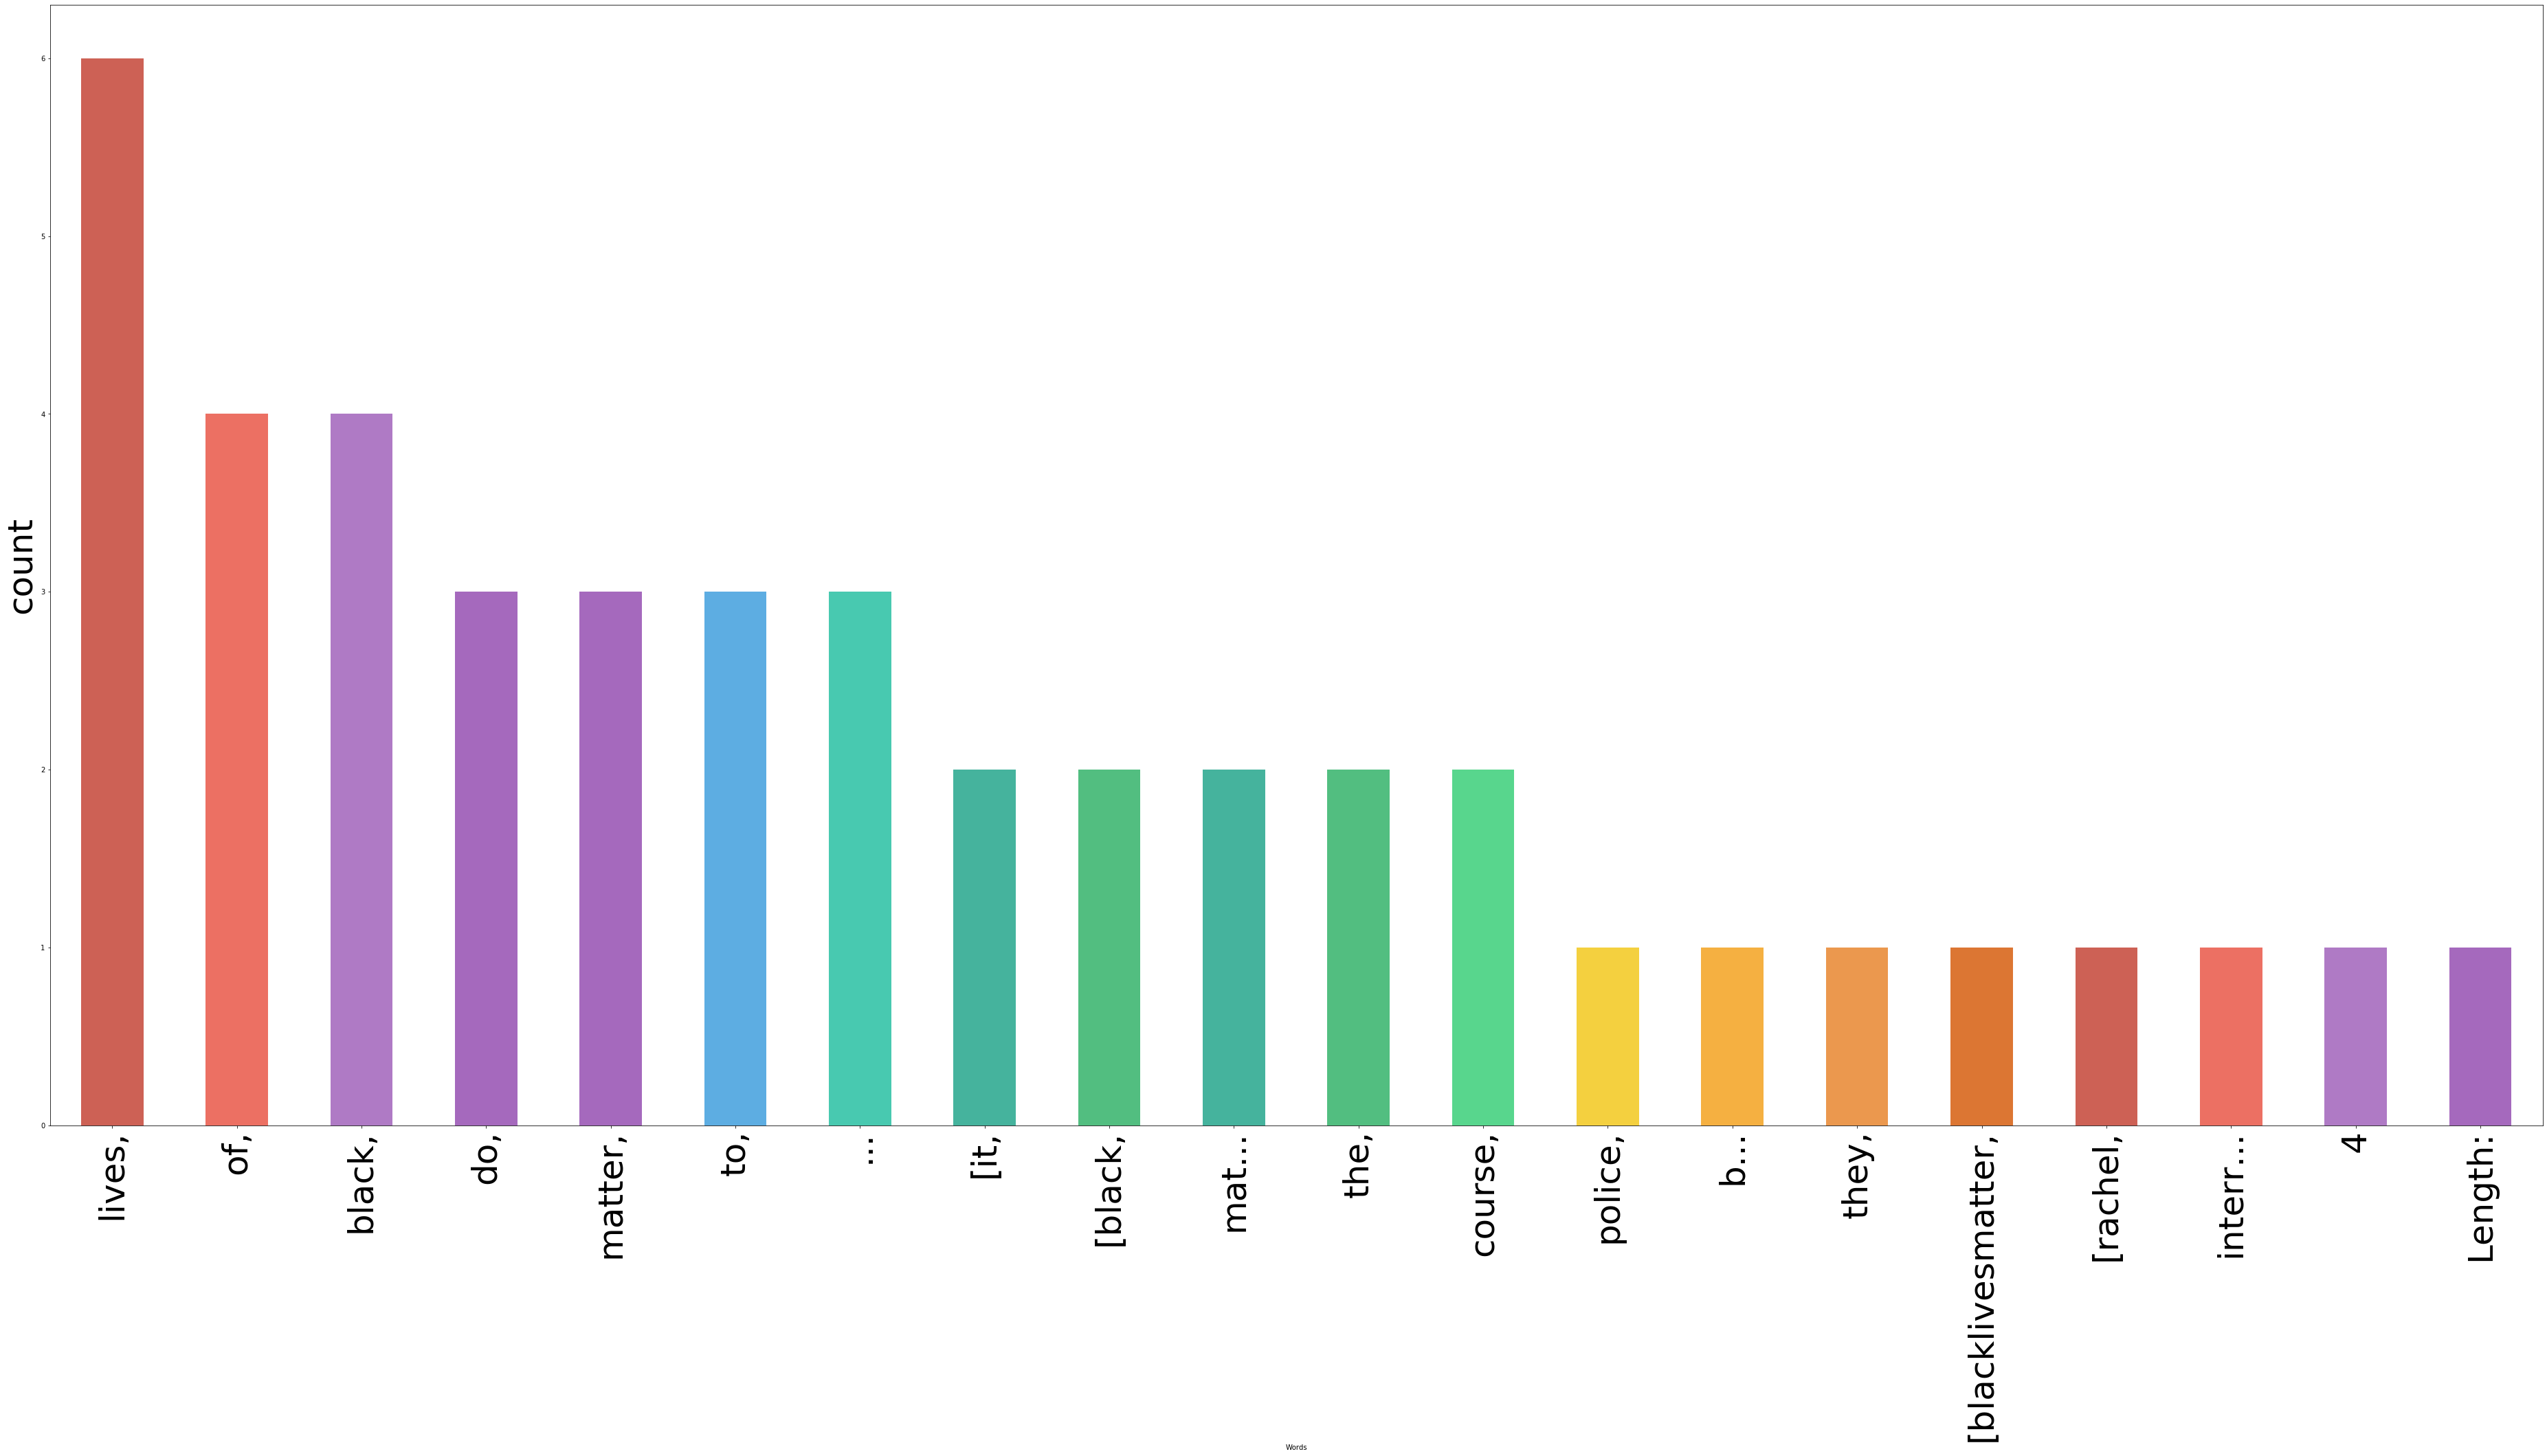

In [13]:
#trying to plot word frequencies of words
 
plt.figure(figsize=(65,30))
series = pd.Series(str(df_nl['Tokenized']).split()).value_counts()
series_count=series[:20]
series_plot=series_count.plot.bar(color=epic_colors)
plt.xticks(rotation=90, fontsize=50)
plt.xlabel("Words")
plt.ylabel("count",fontsize=50)
print(series)
plt.show()


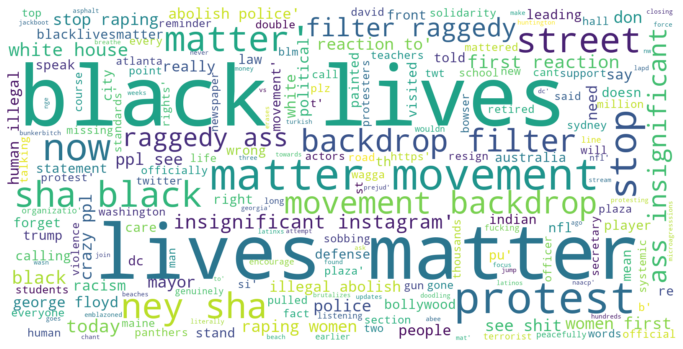

In [14]:
#wordcloud of all the words

print()
wordcloud = WordCloud(width=1600, height=800,max_font_size=200, background_color="white").generate(str(data["Cleaned Tweets"]))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
print()


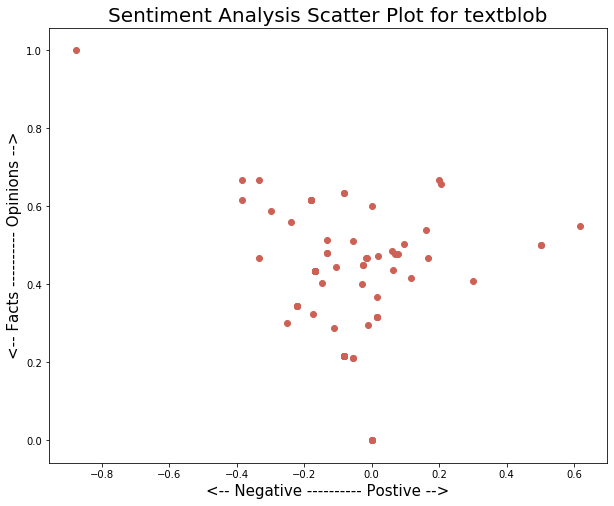

In [28]:
#scatterplot of textboob

%matplotlib inline

plt.rcParams['figure.figsize'] =[10,8]

x=data['Polarity']
y=data['Subject']
plt.scatter(x,y,color=redshadeone)

plt.title('Sentiment Analysis Scatter Plot for textblob', fontsize=20)
plt.xlabel('<-- Negative ---------- Postive -->',fontsize=15)
plt.ylabel('<-- Facts ---------- Opinions -->',fontsize=15)
plt.show()

print()

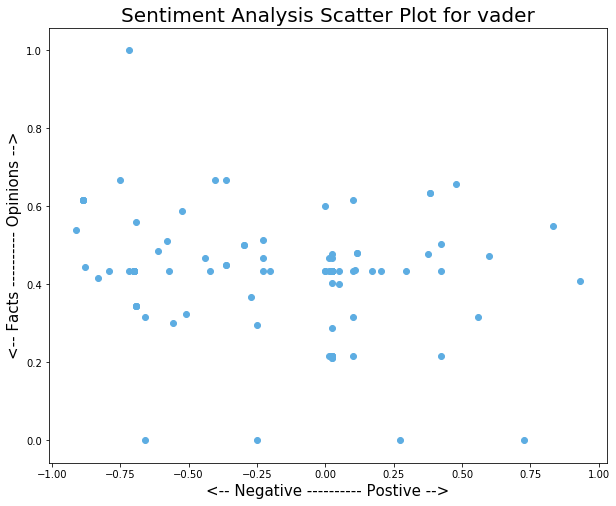

In [29]:
#scatter plot of VADER


%matplotlib inline

plt.rcParams['figure.figsize'] =[10,8]

x=data['Vader Compound']
y=data['Subject']
plt.scatter(x,y,color=bluetwo)

plt.title('Sentiment Analysis Scatter Plot for vader', fontsize=20)
plt.xlabel('<-- Negative ---------- Postive -->',fontsize=15)
plt.ylabel('<-- Facts ---------- Opinions -->',fontsize=15)
plt.show()
print()


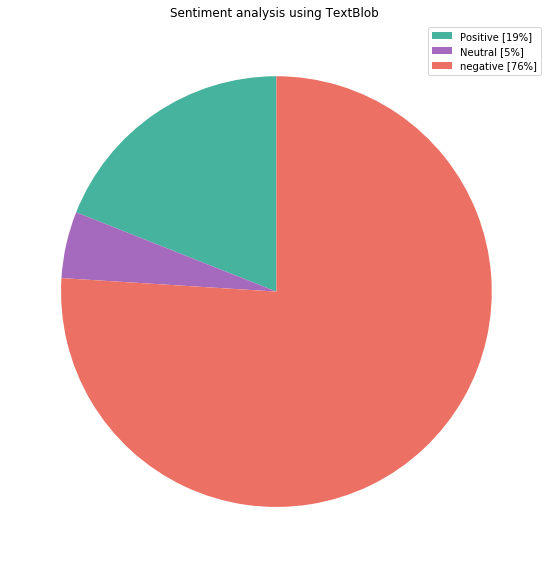

In [17]:
# pie chart of percentage of +ve -ve netutral for text blob

positive_percent=positive/100
negative_percent=negative/100
neutral_percent=neutral/100

positive_percent=format(positive,'.2f')
negative_percent=format(negative,'.2f')
neutral_percent=format(neutral,'.2f')


positive_vader_percent=positive_vader/100
negative_vader_percent=negative_vader/100
neutral_vader_percent=neutral_vader/100

positive_vader_percent=format(positive_vader,'.2f')
negative_vader_percent=format(negative_vader,'.2f')
neutral_vader_percent=format(neutral_vader,'.2f')
        

        
labels =['Positive ['+str(positive)+'%]', 'Neutral ['+str(neutral)+'%]', 'negative ['+str(negative)+'%]']
sizes = [positive_percent,neutral_percent,negative_percent]

patches, text = plt.pie(sizes,colors=colors,startangle=90)
plt.legend(patches,labels,loc="best")
plt.title("Sentiment analysis using TextBlob ")
plt.axis=('equal')
plt.tight_layout()
plt.show()

print()

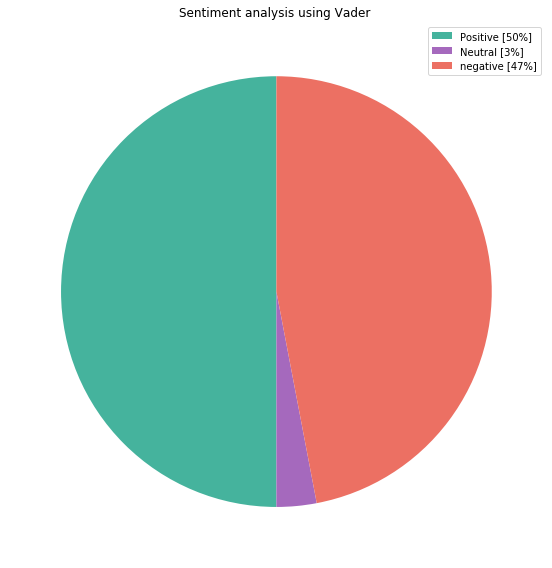

In [18]:
# pie chart of VADER
labels =['Positive ['+str(positive_vader)+'%]', 'Neutral ['+str(neutral_vader)+'%]', 'negative ['+str(negative_vader)+'%]']
sizes_vader = [positive_vader_percent,neutral_vader_percent,negative_vader_percent]

patches, text = plt.pie(sizes_vader,colors=colors,startangle=90)
plt.legend(patches,labels,loc="best")
plt.title("Sentiment analysis using Vader ")
plt.axis=('equal')
plt.tight_layout()
plt.show()

print()


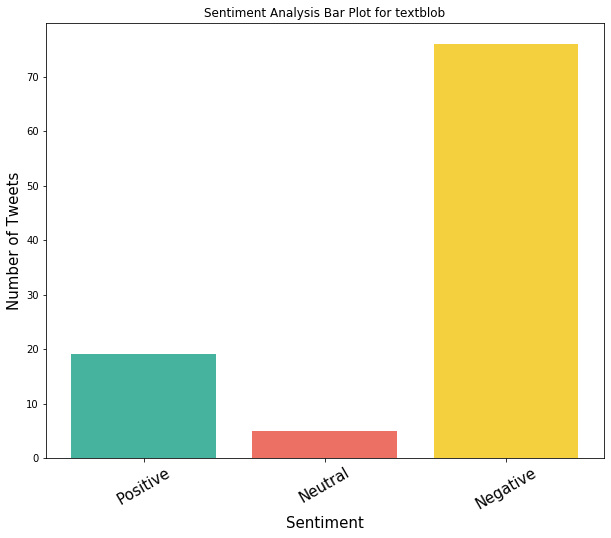

In [30]:
# bar graph of positive negative neutral

bar_list=[positive,neutral,negative]

label=['Positive','Neutral','Negative']


index = np.arange(len(label))
plt.bar(index, bar_list, color=epic_colors_senti_bar)
plt.xlabel('Sentiment', fontsize=15)
plt.ylabel('Number of Tweets', fontsize=15)
plt.xticks(index, label, fontsize=15, rotation=30)
plt.title('Sentiment Analysis Bar Plot for textblob')
plt.show()

print()

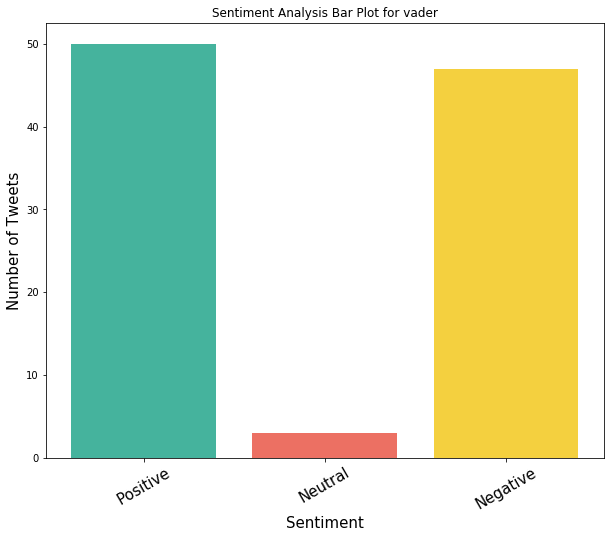

In [31]:
# bar grapph of DARTH VADER

bar_list_vader=[positive_vader,neutral_vader,negative_vader]

label=['Positive','Neutral','Negative']


index = np.arange(len(label))
plt.bar(index, bar_list_vader, color=epic_colors_senti_bar)
plt.xlabel('Sentiment', fontsize=15)
plt.ylabel('Number of Tweets', fontsize=15)
plt.xticks(index, label, fontsize=15, rotation=30)
plt.title('Sentiment Analysis Bar Plot for vader')
plt.show()

print()

negative list of tweets


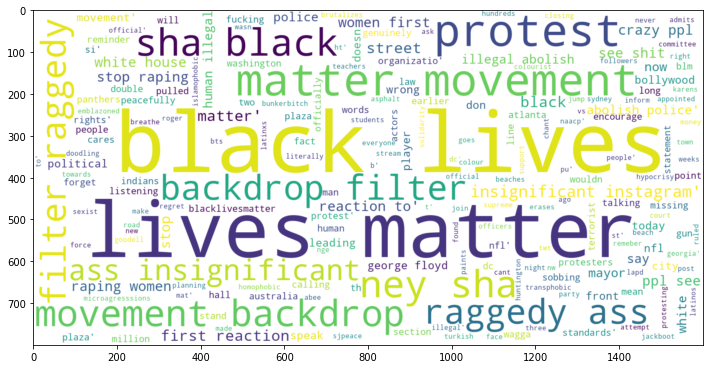

In [21]:
# word cloud of -ve words
print("negative list of tweets")
neg_list=df['Cleaned Tweets'][df.Polarity<0].values.tolist() # if statements cant work i guess?
#print(neg_list)
wordcloud = WordCloud(width=1600, height=800,max_font_size=200, background_color="white").generate(str(neg_list))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
#plt.axis("off")
#plt.margins(x=0, y=0)
plt.show()
print()


Positive list of tweets



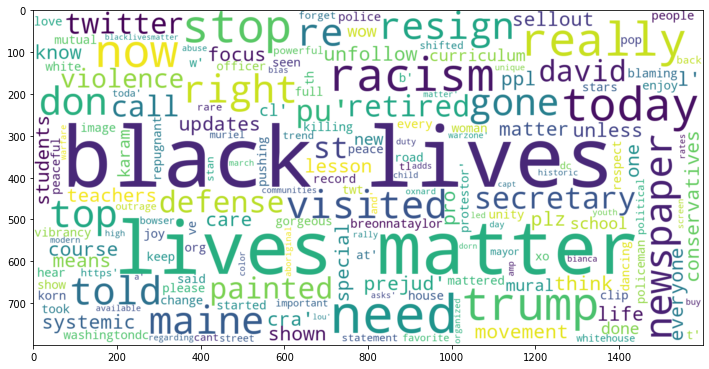

In [22]:
#wordcloud of +ve words
print()
print("Positive list of tweets")
pos_list=df['Cleaned Tweets'][df.Polarity>0].values.tolist()
#print(pos_list)
print()
wordcloud = WordCloud(width=1600, height=800,max_font_size=200, background_color="white").generate(str(pos_list))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
#plt.axis("off")
#plt.margins(x=0, y=0)
plt.show()
print()



neutral list of tweets



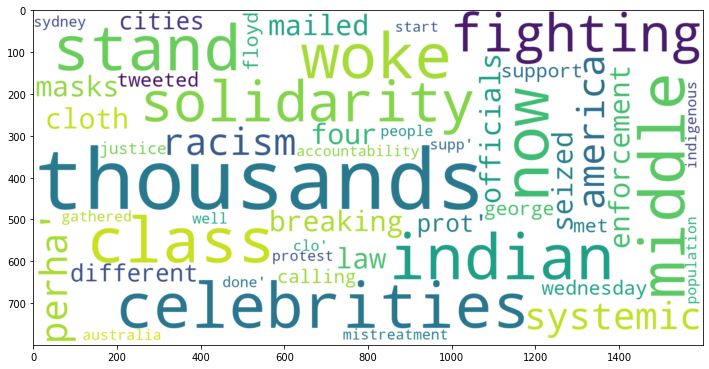

In [23]:
print()
print("neutral list of tweets")
neu_list=df['Cleaned Tweets'][df.Polarity==0].values.tolist()
#print(neu_list)
print()
wordcloud = WordCloud(width=1600, height=800,max_font_size=200, background_color="white").generate(str(neu_list))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
#plt.axis("off")
#plt.margins(x=0, y=0)
plt.show()
print()
tag_dict = {}
mention_dict = {}

Top 10 hashtags:
----------------
blacklivesmatter - 3
austinprotests - 1
auspol2020 - 1
aboriginaldeathsincustody - 1
racism - 1
breonnataylor - 1
icantbreathe - 1
washingtondc - 1
bts - 1
bunkerbitch - 1


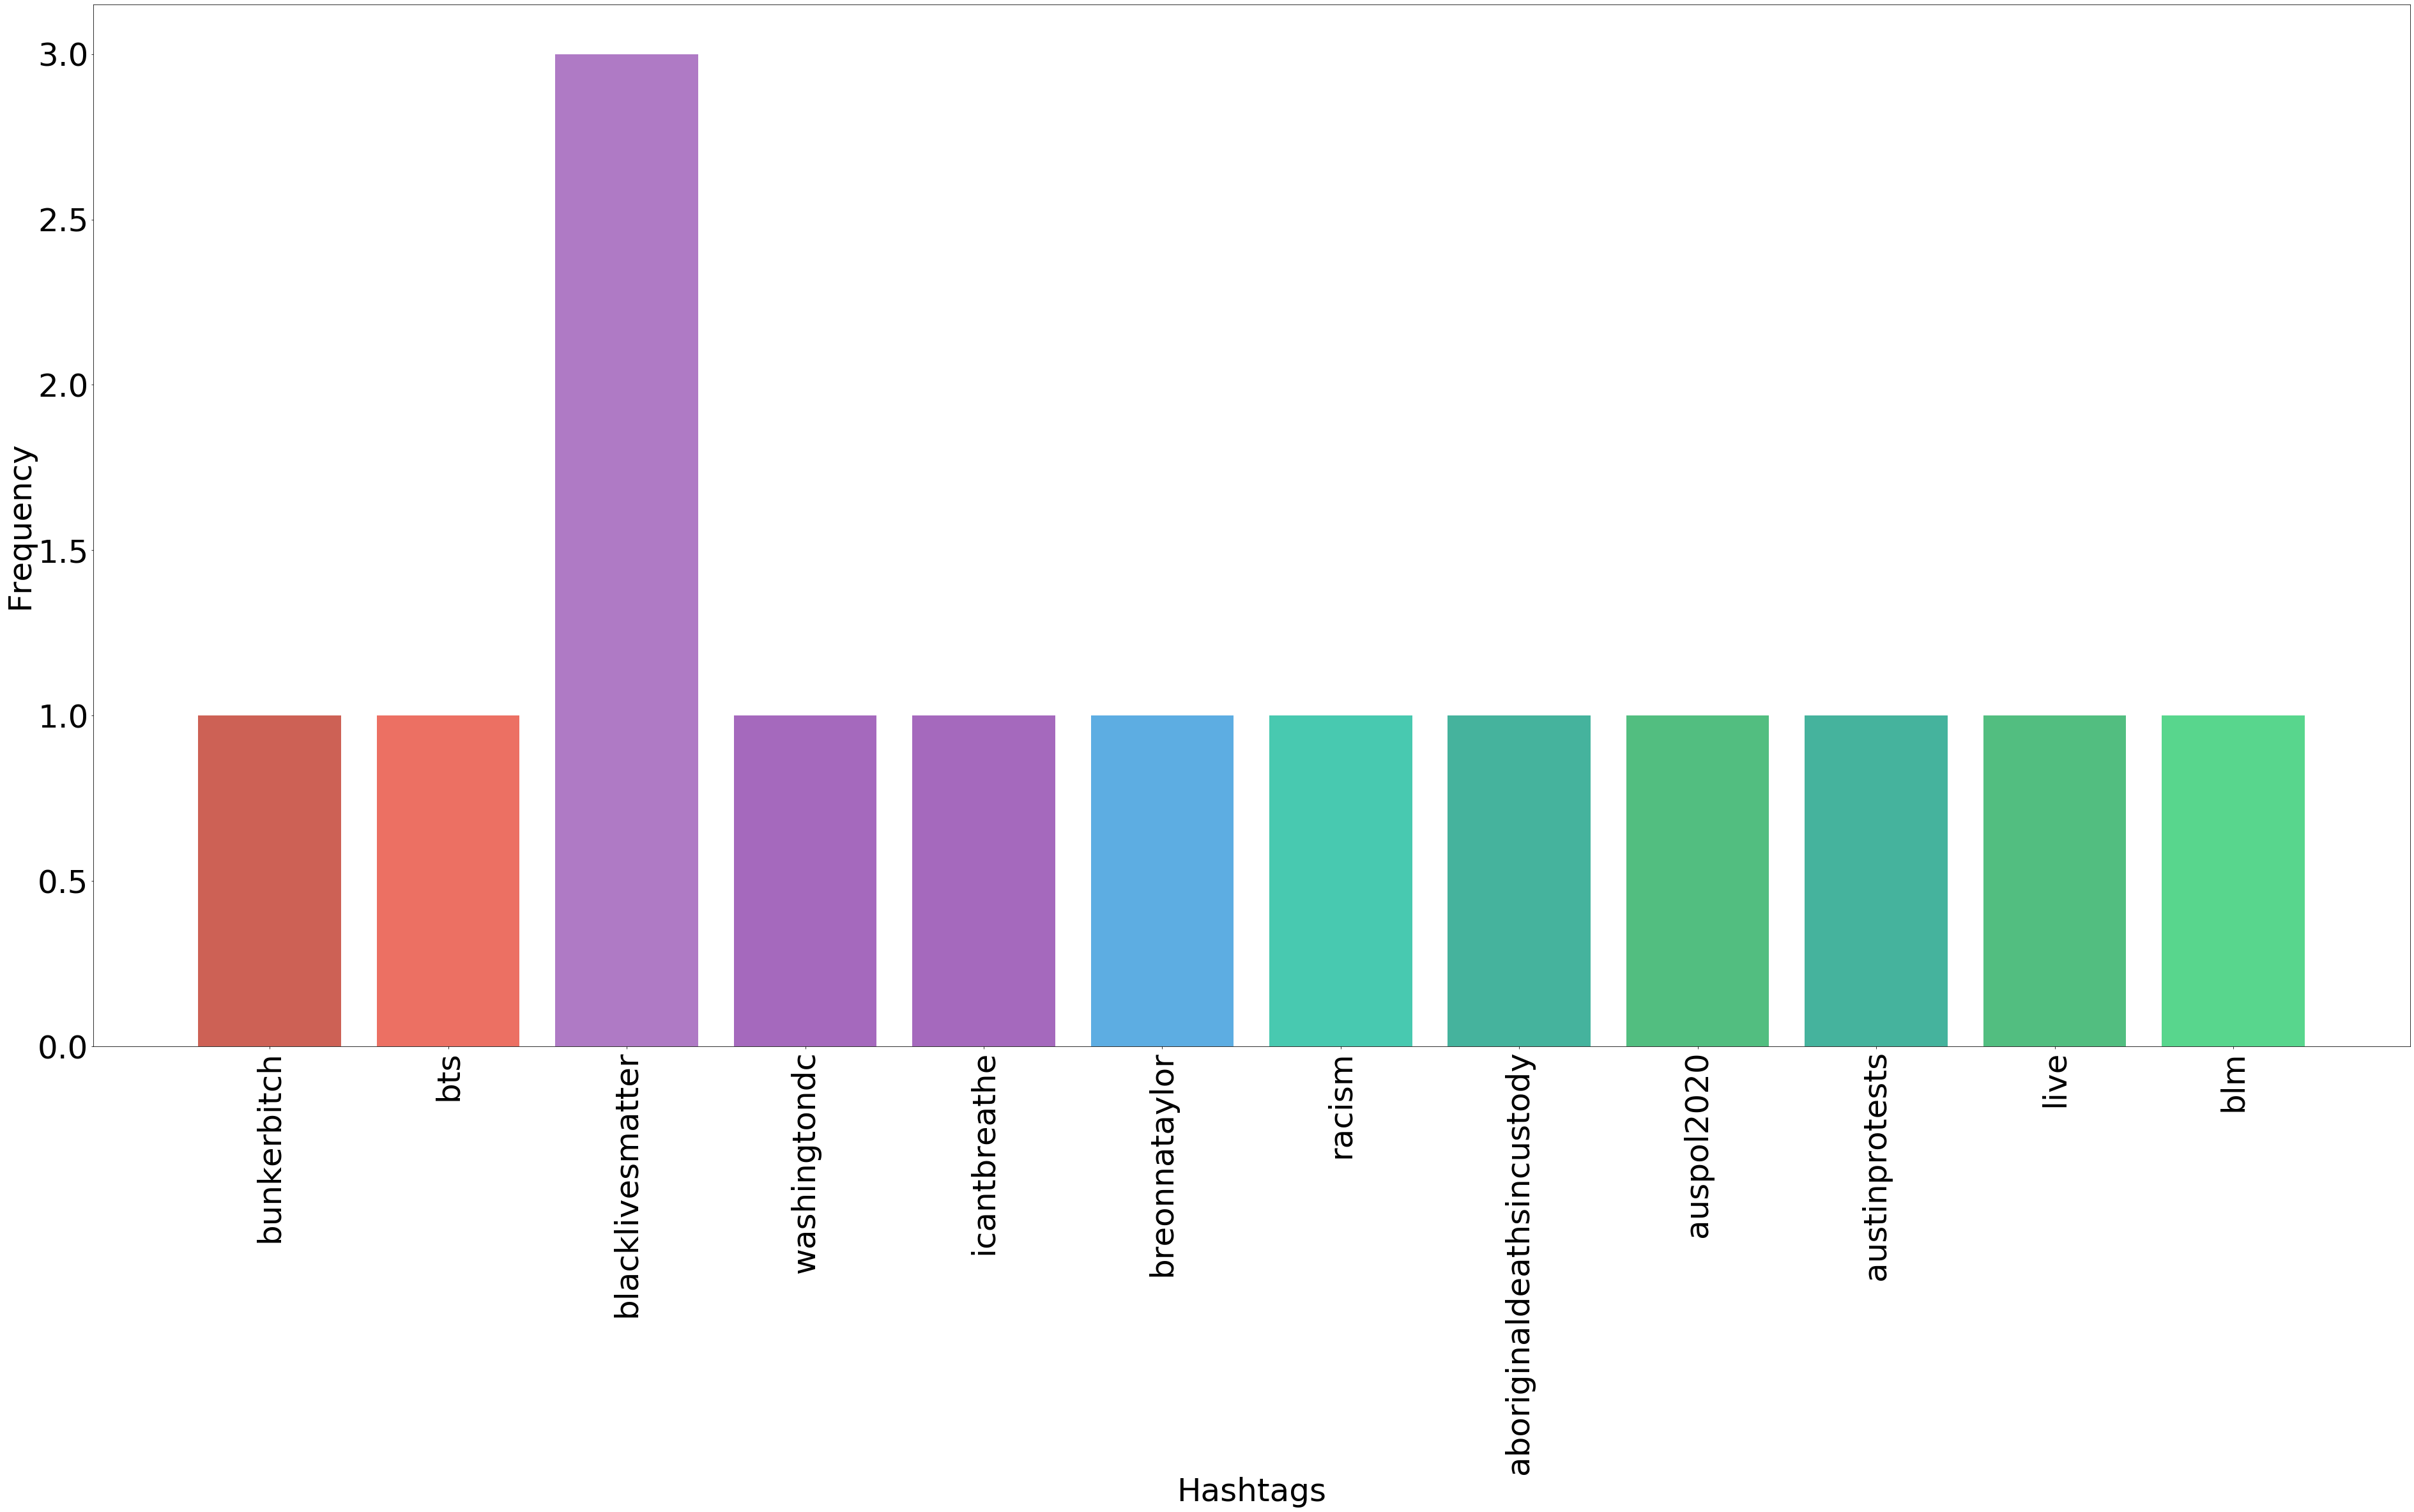

In [24]:
#top 10 most used hashtags

import operator

for i in df.index:
    tweet_text = df.iloc[i]['Tweets']
    tweet = tweet_text.lower()
    tweet_token = tweet.split()
    
    for word in tweet_token:
        if(word[0:1] == '#' and len(word)>1):
            key = word.translate(str.maketrans('','',string.punctuation))
            if key in tag_dict:
                tag_dict[key] += 1
            else:
                tag_dict[key] = 1
top_tags = dict(sorted(tag_dict.items(), key=operator.itemgetter(1), reverse=True)[:10])
top_tags_sorted = sorted(top_tags.items(), key=lambda x: x[1])[::-1]
print ('Top 10 hashtags:')
print ('----------------')
for tag in top_tags_sorted:
    print (tag[0], '-', str(tag[1]))

hash_keys = tag_dict.keys()
hash_values = tag_dict.values()


plt.figure(figsize=(65,30))
plt.xlabel('Hashtags', fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.xticks(fontsize=50, rotation=90)
plt.yticks(fontsize=50)
plt.bar(hash_keys,hash_values, color=epic_colors)
plt.show()
print()
print()


In [25]:
#buildin wordlist

from collections import Counter
words=Counter()
for idx in df_nl.index:
    words.update(df_nl.loc[idx,"Tokenized"])
'''#print(words.most_common(5))
print()
#print(words)
print()
#make a better plot next time 
print()
plt.figure(figsize=(300,200))
plt.bar(words.keys(),words.values(),color=epic_colors)
plt.xticks(rotation=90, fontsize=50)
plt.xlabel("Words")
plt.ylabel("count",fontsize=50)

plt.show()'''


'#print(words.most_common(5))\nprint()\n#print(words)\nprint()\n#make a better plot next time \nprint()\nplt.figure(figsize=(300,200))\nplt.bar(words.keys(),words.values(),color=epic_colors)\nplt.xticks(rotation=90, fontsize=50)\nplt.xlabel("Words")\nplt.ylabel("count",fontsize=50)\n\nplt.show()'

# Creating bag of words and running NB classifier

In [26]:
#making bag of words
word_list=np.array(list(words.keys())) # this is a feature matrix basically

def bow(tweet):
    words_dictionary = dict([word,True] for word in word_list)
    return words_dictionary
    print(words_dictionary)

# i already have pos tweets and neg tweets as pos_list, neg_list and neu_list
print("*____________________*")
print("length of positive and negative list of tweets")
print(len(pos_list),len(neg_list))

#training classifier and calculatin gaccuracy

from nltk import classify
from nltk import NaiveBayesClassifier



#creating train set and test set

from random import shuffle 

pos_tweets_set = []
neg_tweets_set = []
for tweet in pos_list:
    pos_tweets_set.append((bow(tweet),'pos'))

for tweet in neg_list:
    neg_tweets_set.append((bow(tweet), 'neg'))

#going to randomize pos and neg tweets brrruuuHHHH
shuffle(pos_tweets_set)
shuffle(neg_tweets_set)
# I shuffle cards better than this crap


# we gon take 20% of the list of  tweets 

# doing this calculation cause youre useless at times python :"D

twenty_percent_pos=(len(pos_tweets_set)*0.2)
twenty_percent_neg=(len(neg_tweets_set)*0.2)

test_set = pos_tweets_set[:int(twenty_percent_pos)]+neg_tweets_set[:int(twenty_percent_neg)]

train_set = pos_tweets_set[int(twenty_percent_pos):]+neg_tweets_set[int(twenty_percent_neg):]
print("*____________________*")
print("length of positive and negative list of tweets for train and test sets, 20% was taken")
print(len(test_set),  len(train_set))
print()

# taraining the classifier and calculating accuracy

from nltk import classify
from nltk import NaiveBayesClassifier


classifier = NaiveBayesClassifier.train(train_set)

accuracy = classify.accuracy(classifier, test_set)
print()
print("Accuracy is -->")
print(accuracy)

print()
print()
print(classifier.show_most_informative_features(10))
print()

from collections import defaultdict
 
actual_set = defaultdict(set)
predicted_set = defaultdict(set)
 
actual_set_cm = []
predicted_set_cm = []
 
for index, (feature, actual_label) in enumerate(test_set):
    actual_set[actual_label].add(index)
    actual_set_cm.append(actual_label)
 
    predicted_label = classifier.classify(feature)
 
    predicted_set[predicted_label].add(index)
    predicted_set_cm.append(predicted_label)
    

*____________________*
length of positive and negative list of tweets
19 76
*____________________*
length of positive and negative list of tweets for train and test sets, 20% was taken
18 77


Accuracy is -->
0.8333333333333334


Most Informative Features
                    then = True              neg : pos    =      1.0 : 1.0
                    show = True              neg : pos    =      1.0 : 1.0
                   using = True              neg : pos    =      1.0 : 1.0
                 downing = True              neg : pos    =      1.0 : 1.0
                  resign = True              neg : pos    =      1.0 : 1.0
                     ain = True              neg : pos    =      1.0 : 1.0
                officers = True              neg : pos    =      1.0 : 1.0
                 officer = True              neg : pos    =      1.0 : 1.0
                 raggedy = True              neg : pos    =      1.0 : 1.0
                  showed = True              neg : pos    =      1.0 

# Predicting overall sentiment using confusion matrix 

In [27]:
from nltk.metrics import precision, recall, f_measure, ConfusionMatrix

print ('pos precision:', precision(actual_set['pos'], predicted_set['pos']))
print('pos recall:', recall(actual_set['pos'], predicted_set['pos']) )
print('pos F-measure:', f_measure(actual_set['pos'], predicted_set['pos']) )
print()
print('neg precision:', precision(actual_set['neg'], predicted_set['neg']))
print('neg recall:', recall(actual_set['neg'], predicted_set['neg']))
print('neg F-measure:', f_measure(actual_set['neg'], predicted_set['neg']))



#adding confusion matrix 
# Confusion Matrix is a table that is used to describe the performance of the classifier.

cm = ConfusionMatrix(actual_set_cm, predicted_set_cm)
print (cm)
print()
print()
print (cm.pretty_format(sort_by_count=True, show_percents=True, truncate=9))




pos precision: None
pos recall: 0.0
pos F-measure: None

neg precision: 0.8333333333333334
neg recall: 1.0
neg F-measure: 0.9090909090909091
    |  n  p |
    |  e  o |
    |  g  s |
----+-------+
neg |<15> . |
pos |  3 <.>|
----+-------+
(row = reference; col = test)



    |      n      p |
    |      e      o |
    |      g      s |
----+---------------+
neg | <83.3%>     . |
pos |  16.7%     <.>|
----+---------------+
(row = reference; col = test)



# 

# 

# 

# 